## Classify classical music by era

### imports

In [1]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util
import numpy as np
import pandas as pd
import seaborn as sns

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

### auth

In [104]:
cid ="2bd837c837174d50ab873c61acf24f68" 
secret = "033bb4a851d54615bf83aaf94239ee06"
username = "omkwppodx5qi1pph0cwma65zc"
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret) 
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
scope = 'user-library-read playlist-read-private streaming user-modify-playback-state user-read-playback-state playlist-modify-private'
token = util.prompt_for_user_token(username, scope, client_id=cid, client_secret=secret, redirect_uri="http://localhost/")
if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("Can't get token for", username)

### get data

In [116]:
composers = pd.read_csv("~/Documents/_dataScience/projects/spotify_api/sp-classical-classifier/data/raw/composer_era.csv")

In [117]:
composers

,firstnames,lastnames,era
0,johann sebastian,bach,baroque
1,george fridrich,handel,baroque
2,antonio,vivaldi,baroque
3,domenico,scarlatti,baroque
4,claudio,monteverdi,baroque
5,georg philipp,telemann,baroque
6,henry,purcell,baroque
7,wolfgang amadeus,mozart,classical
8,william,boyce,baroque
9,carl,stamitz,classical


In [5]:
fnames = composers.firstnames.values
lnames = composers.lastnames.values

In [6]:
queries = [f"this is {lnames[i]}" for i in range(len(composers))]

#### get data
pull artist albums

In [7]:
def get_artist_id_from_name(name: str, id_type: str):
    """id type can be ["genres", "name", "id", "uri"]"""
    search = sp.search(name, limit=1, type="artist")
    return search["artists"]["items"][0][id_type]


def get_playlist_id_from_name(name: str) -> list:
    search = sp.search(name, limit=1, type="playlist")
    pl_id = search["playlists"]["items"][0]["id"]
    pl_name = search["playlists"]["items"][0]["name"]
    pl_uri = search["playlists"]["items"][0]["uri"]
    return [pl_id, pl_name, pl_uri]


def get_essentials_album_ids_from_name(name: str, id_type: str):
    query = f"{name} essentials"
    search = sp.search(query, limit=10, type="album")["albums"]["items"]
    ids_list = [result[id_type] for result in search]
    return ids_list


def get_album_ids_from_name(name: str, id_type: str) -> list:
    """takes composer fname + lname and returns up to 20 of their artist albums"""
    artist = get_artist_id_from_name(name=name, id_type="id")
    albums = sp.artist_albums(artist, limit=20)
    return [albums["items"][i]["id"] for i in range(len(albums["items"]))]
    
    
def get_album_track_ids(album_id: str, id_type: str) -> list:
    """takes album id and returns list track [id_type]s"""
    tracks = sp.album_tracks(album_id)["items"]
    return [tracks[i][id_type] for i in range(len(tracks))]
    
    
def get_playlist_track_ids(playlist_id: str, id_type: str) -> list:
    # id_type = ["uri", "name", "id"]
    tracks = sp.playlist_tracks(playlist_id)["items"]
    track_ids = [tracks[i]["track"][id_type] for i in range(len(tracks))]
    return track_ids


def get_audio_features_as_lists(track_id: str, keys_list: list):
    track = sp.audio_features(track_id)
    features_list = []
    for key in keys_list:
        try:
            features_list.append(track[0][key])
        except: 
            continue
    return features_list

def get_track_name_from_id(track_id: str):
    return sp.track(track_id)["name"]

features = ['danceability', 'energy', 'key', 'loudness', 'mode', 'valence', 'tempo', 'time_signature']
rows_list = []
for i in range(len(composers[0:4])):
    name = f"{composers['firstnames'][i]} {composers['lastnames'][i]}"
    print(name)
    era = composers["era"][i]
    
    album_ids = get_album_ids_from_name(name, "id")
    album_name = get_album_ids_from_name(name, "name")
    track_ids = []
    track_names = []
    for album_id in album_ids:
        if album_id == "5OfGONHFJZD8xpz3gVBwYz":  # this is a specific bad album
            pass
        else:
            try:
                album_tracks = get_album_track_ids(album_id, "id")
                album_track_names = get_album_track_ids(album_id, "name")
                track_ids += album_tracks
                track_names += album_track_names
            except IndexError:
                pass
    
    for j in range(len(track_ids)):
        features_list = get_audio_features_as_lists(track_ids[j], keys_list=features)
        rows_list.append([track_ids[j]] + [track_names[j]] + features_list + [era])

colnames = ["track_id", "track_name"] + features + ["era"]
df = pd.DataFrame(columns=colnames, data=rows_list)      
        
    

colnames = ["track_id", "track_name"] + features + ["era"]
df = pd.DataFrame(columns=colnames, data=rows_list)  

df["era_encode"] = np.where(df.era == "baroque", 0, 
                   np.where(df.era == "classical", 1,
                   np.where(df.era == "romantic", 2, np.nan)))

print(f"baroque: {df[df.era_encode==0].shape}")
print(f"classical: {df[df.era_encode==1].shape}")
print(f"romantic: {df[df.era_encode==2].shape}")

df = df[(df.danceability != "baroque") & (df.danceability != "romantic")]
df = df.astype({"danceability": "float"})

In [9]:
df = pd.read_csv("~/Documents/_dataScience/projects/spotify_api/sp-classical-classifier/data/raw/track_data.csv")

In [10]:
features

['danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'valence',
 'tempo',
 'time_signature']

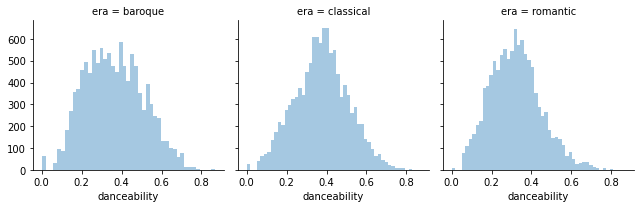

In [11]:
g = sns.FacetGrid(df, col="era")
g = g.map(sns.distplot, "danceability", kde=False)

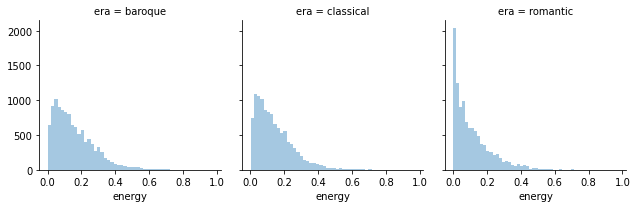

In [12]:
g = sns.FacetGrid(df, col="era")
g = g.map(sns.distplot, "energy", kde=False)

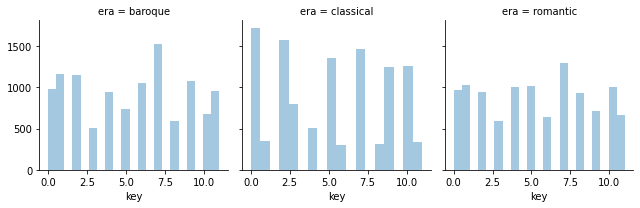

In [13]:
g = sns.FacetGrid(df, col="era")
g = g.map(sns.distplot, "key", kde=False)

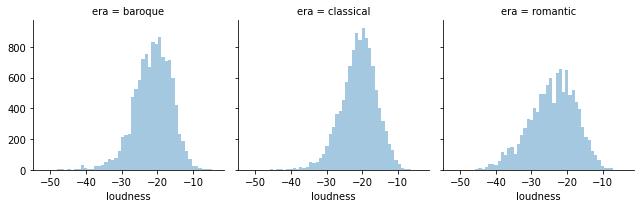

In [14]:
g = sns.FacetGrid(df, col="era")
g = g.map(sns.distplot, "loudness", kde=False)

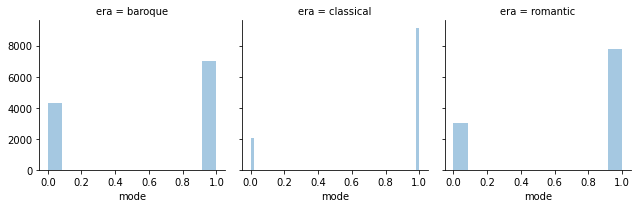

In [15]:
g = sns.FacetGrid(df, col="era")
g = g.map(sns.distplot, "mode", kde=False)

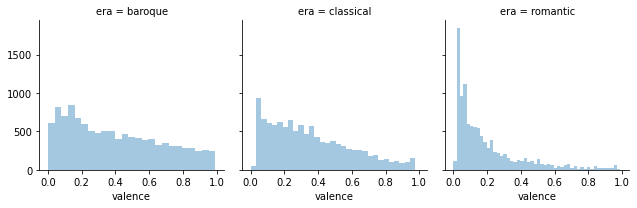

In [16]:
g = sns.FacetGrid(df, col="era")
g = g.map(sns.distplot, "valence", kde=False)

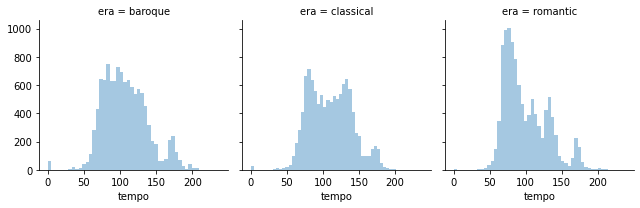

In [17]:
g = sns.FacetGrid(df, col="era")
g = g.map(sns.distplot, "tempo", kde=False)

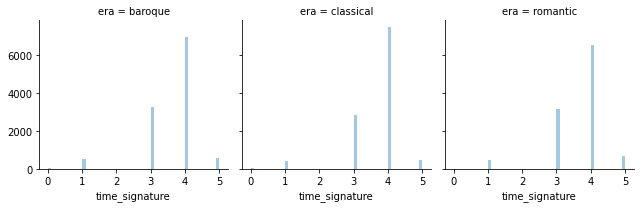

In [18]:
g = sns.FacetGrid(df, col="era")
g = g.map(sns.distplot, "time_signature", kde=False)

### Train-Test Split

In [19]:
X = df[features].values
y = df["era_encode"]

In [20]:
## split train:test:validate = 70:20:10
X_train, X_tests, y_train, y_tests = train_test_split(X, y, test_size=0.3, random_state=5)
X_test, X_validate, y_test, y_validate = train_test_split(X_tests, y_tests, test_size=0.333, random_state=5)

In [21]:
## check split
tot = sum([X_train.shape[0], X_test.shape[0], X_validate.shape[0]])
print(round(X_train.shape[0]/tot, 2), round(X_test.shape[0]/tot, 2), round(X_validate.shape[0]/tot, 2))

0.7 0.2 0.1


In [22]:
## check distr of eras
def get_prop(vec, i):
    return round(len(vec[vec==i])/len(vec), 2)
print("y_train:", [get_prop(y_train, era) for era in [0, 1, 2]])
print("y_test:", [get_prop(y_test, era) for era in [0, 1, 2]])
print("y_validate:", [get_prop(y_validate, era) for era in [0, 1, 2]])

y_train: [0.34, 0.34, 0.32]
y_test: [0.35, 0.33, 0.33]
y_validate: [0.34, 0.33, 0.33]


### Preproccessing

In [23]:
## scale to 0-1:
scaler = MinMaxScaler()
X_test = scaler.fit_transform(X_test)
X_train = scaler.fit_transform(X_train)
X_validate = scaler.fit_transform(X_validate)


In [24]:
## normalise:
X_test = normalize(X_test, norm="l2")
X_train = normalize(X_train, norm="l2")
X_validate = normalize(X_validate, norm="l2")

In [26]:
y_train = y_train.astype("int")
y_test = y_test.astype("int")
y_validate = y_validate.astype("int")

### Neural Network:

In [27]:
clf = MLPClassifier(hidden_layer_sizes=(100, 100), activation="relu", solver="adam", random_state=5, max_iter=500)

In [28]:
clf.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=500, random_state=5)

In [29]:
y_pred = clf.predict(X_test)

In [30]:
np.sqrt(np.mean((y_pred - y_test)**2))

0.8768410616179134

##### Neural Network Evaluation:

In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.54      0.58      2311
           1       0.57      0.49      0.53      2173
           2       0.59      0.74      0.66      2187

    accuracy                           0.59      6671
   macro avg       0.59      0.59      0.59      6671
weighted avg       0.59      0.59      0.59      6671



### Linear Regression:

In [32]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [33]:
y_pred_lr = lin_reg.predict(X_test)

In [34]:
np.sqrt(np.mean((y_pred_lr - y_test)**2))

0.7618907994495451

In [37]:
rslt = pd.DataFrame({"pred": y_pred_lr, "actual": y_test})

In [39]:
rslt.groupby(by=["actual"])["pred"].median()

actual
0    0.897051
1    1.012650
2    1.219350
Name: pred, dtype: float64

### Gaussian process classifier:

gpc = GaussianProcessClassifier(random_state=5)
gpc.fit(X_train, y_train)

y_pred_gpc = gpc.predict(y_test)

print(classification_report(y_test, y_pred_gpc))

### Random Forest:

In [60]:
rf = RandomForestClassifier(n_estimators=1000, criterion="gini", random_state=5)

In [61]:
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000, random_state=5)

In [62]:
y_pred_rf = rf.predict(X_test)

In [63]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.72      0.69      0.70      2311
           1       0.66      0.66      0.66      2173
           2       0.74      0.77      0.75      2187

    accuracy                           0.70      6671
   macro avg       0.70      0.70      0.70      6671
weighted avg       0.70      0.70      0.70      6671



In [42]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.71      0.68      0.70      2311
           1       0.65      0.66      0.65      2173
           2       0.74      0.76      0.75      2187

    accuracy                           0.70      6671
   macro avg       0.70      0.70      0.70      6671
weighted avg       0.70      0.70      0.70      6671



In [67]:
y_pred_rf

array([1, 2, 0, ..., 0, 1, 1])

In [69]:
df.shape

(33338, 12)

In [75]:
test_tracks = pd.DataFrame(y_test)
test_tracks["pred"] = y_pred_rf
test_tracks["diff"] = test_tracks.era_encode - test_tracks.pred

In [76]:
test_tracks.head()

,era_encode,pred,diff
14694,1,1,0
25913,2,2,0
1286,0,0,0
6917,0,0,0
1891,0,0,0


In [77]:
test_df = df.merge(test_tracks, how="inner", left_index=True, right_index=True)

In [85]:
test_df = test_df[test_df["diff"] != 0]

In [86]:
test_df.head()

,Unnamed: 0,track_id,danceability,energy,key,loudness,mode,valence,tempo,time_signature,era,era_encode_x,era_encode_y,pred,diff
5,5,4wIqzH5G9GUmQTFfh4yxf5,0.503,0.02360,7.0,-24.251,1.0,0.6870,118.847,5.0,baroque,0.0,0,1,-1
14,14,4phoMGdd4KHJ9R2vxSueOa,0.499,0.10600,0.0,-25.290,1.0,0.8330,88.955,4.0,baroque,0.0,0,1,-1
16,16,3Ror6mdgBpRxwNogVehe8H,0.384,0.04280,0.0,-25.723,1.0,0.5920,75.640,3.0,baroque,0.0,0,1,-1
21,21,6QxvKmbPw9nARCiw1a1QpR,0.381,0.00344,3.0,-26.471,1.0,0.3550,120.842,5.0,baroque,0.0,0,2,-2
27,27,3UjnAjOB5Vb3aaWU1Bufdv,0.210,0.00385,0.0,-30.866,0.0,0.0805,84.100,4.0,baroque,0.0,0,2,-2


In [92]:
not_baroque = test_df[test_df["pred"] == 0]
not_classical = test_df[test_df["pred"] == 1]
not_romantic = test_df[test_df["pred"] == 2]

In [101]:
not_baroque_tracks = not_baroque["track_id"].values[0:90]
not_classical_tracks = not_classical["track_id"].values[0:90]
not_romantic_tracks = not_romantic["track_id"].values[0:90]

In [111]:
baroque_id = sp.user_playlist_create(user="omkwppodx5qi1pph0cwma65zc", name="not baroque", public=False)["id"]
classical_id = sp.user_playlist_create(user="omkwppodx5qi1pph0cwma65zc", name="not classical", public=False)["id"]
romantic_id = sp.user_playlist_create(user="omkwppodx5qi1pph0cwma65zc", name="not romantic", public=False)["id"]

In [112]:
sp.user_playlist_add_tracks(user="omkwppodx5qi1pph0cwma65zc", playlist_id=baroque_id, tracks=not_baroque_tracks)

{'snapshot_id': 'MyxiNjA5NDA5YmFjMzY5ZGI4MmVkY2E0YWE4MTE3MDUxYjAwYmJkOTJi'}

In [113]:
sp.user_playlist_add_tracks(user="omkwppodx5qi1pph0cwma65zc", playlist_id=classical_id, tracks=not_classical_tracks)

{'snapshot_id': 'MywwYmRkM2Y3MWExNDE2ZmFkODg1ZGE4NWE4ZTc5MzlhMjE3ZjJkNzA3'}

In [114]:
sp.user_playlist_add_tracks(user="omkwppodx5qi1pph0cwma65zc", playlist_id=romantic_id, tracks=not_romantic_tracks)

{'snapshot_id': 'MyxmYjg1OTAyYWEwMmJjYzFkZmE5YWZmNWQzNmRjMDE5Mjg2ZjE5Y2U1'}

In [110]:
classical_id

'2rh6e38SA88E0RQoNWtTxt'